In [65]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 8

import warnings
warnings.filterwarnings('ignore')

# Create xarray region mask

In this code we will show how to create a mask for arbitrary latitude and longitude grids using xarray.

Import regionmask and check the version:

In [66]:
import regionmask

'0.4.0'

Load xarray and numpy

In [67]:
import xarray as xr
import numpy as np
# load plotting libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from functions import area_latlon # function to calculate grid area
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script

load the data:

In [68]:
year = '2015'
name_ds = 'ODIAC' # EDGAR, ODIAC, TNO
fname = name_ds + '_' + year + '_1x1.nc'
ds = xr.open_dataset('../' + name_ds + '/nc/' + fname)
ds # check the data type and information within
# ffCO2 emission
dr = ds['emi_co2']
#print(dr.attrs['units']) # 'kg m-2 s-1'
dr.values = dr.values*365*24*3600 # convert unit to: kg m-2
# calculate grid area (using the above defined function) and convert unit to kg/year
for count, lat in enumerate(dr['lat'].values):
    area = area_latlon(lat1=lat, lat2=lat+1, lon1=10, lon2=11) # km^2, also longitude doesn't matter
    dr.values[count,:] = dr.values[count,:]*area # Gg/grid cell

get the variable, and it will become DataArray

import a colormap, this requires a file I downloaded 'gamap_colormap.py'

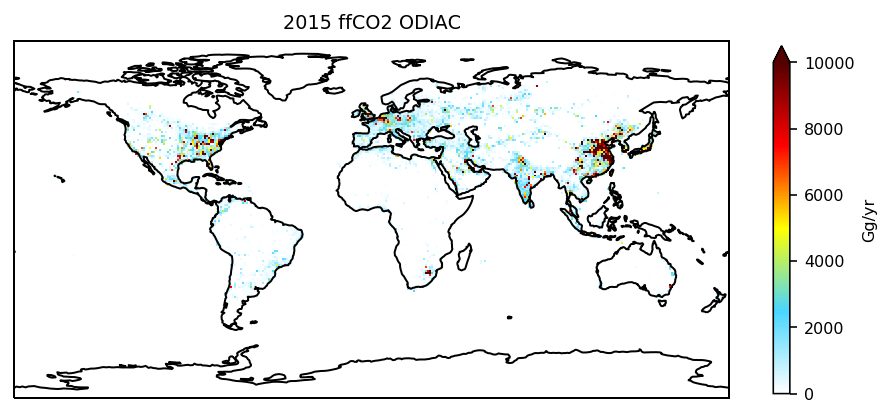

In [69]:
# choose a good projection for regional maps
fig = plt.figure(figsize=[8, 4])
proj=ccrs.PlateCarree()

ax = plt.subplot(111, projection=proj)
ax.coastlines()
dr.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=WhGrYlRd, vmax = 10000, cbar_kwargs={'shrink': 0.8, 'label': 'Gg/yr'})
ax.set_title(year + ' ffCO2 ' + name_ds );

# fig.savefig('./plots/EDGARv5_ffco2_global_2014.png', dpi=300) # save if you need

## regional plot

get a subset of data:

In [70]:
# .sel function is quite powerful, it selects according to coord values, instead of indices
dr_subset = dr.sel(lat=slice(36,64), lon = slice(-11,36)) 
dr_subset

<xarray.DataArray 'emi_co2' (lat: 28, lon: 47)>
array([[0.00000000e+00, 0.00000000e+00, 3.67547926e-02, ...,
        2.14647432e+02, 1.25092206e+03, 3.90763608e+03],
       [0.00000000e+00, 0.00000000e+00, 3.11041769e+03, ...,
        2.64732490e+02, 5.52742558e+02, 1.15243472e+03],
       [0.00000000e+00, 1.53894374e+03, 6.83206486e+02, ...,
        2.55602196e+02, 7.98423465e+02, 1.37357765e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.10768462e+01, 1.14031842e+03, 3.19673544e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.67533812e+01, 1.56652211e+02, 1.28048337e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.03270278e+00, 1.26462612e+02, 6.90638975e-01]])
Coordinates:
  * lon      (lon) float64 -10.5 -9.5 -8.5 -7.5 -6.5 ... 32.5 33.5 34.5 35.5
  * lat      (lat) float64 36.5 37.5 38.5 39.5 40.5 ... 59.5 60.5 61.5 62.5 63.5
Attributes:
    comment:  regridded from 0.1x0.1, by m.sadiq 2020

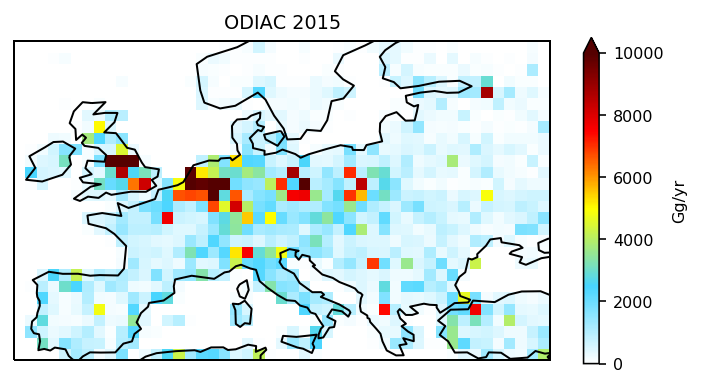

In [71]:
fig = plt.figure(figsize=[6, 6])

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
dr_subset.plot(ax=ax, cmap=WhGrYlRd, vmax=10000, cbar_kwargs={'shrink': 0.5, 'label': 'Gg/yr'})  # The ax keyword is particularly useful for subplots. Can be omitted here.

ax.set_xlim(-11,36)
ax.set_ylim(36,64)

ax.set_title(name_ds+' ' + year);

## making a mask 

Conviniently we can directly pass an xarray object to the `mask` function. It gets the longitude and latitude from the DataArray/ Dataset and creates the `mask`. If the longitude and latitude in the xarray object are not called `lon` and `lat`, respectively; their name can be given via the `lon_name` and `lat_name` keyword. Here we use the 110 countries mask. If your data is very high resolution, it might take a while.

In [72]:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(dr)

Let's plot the regions:

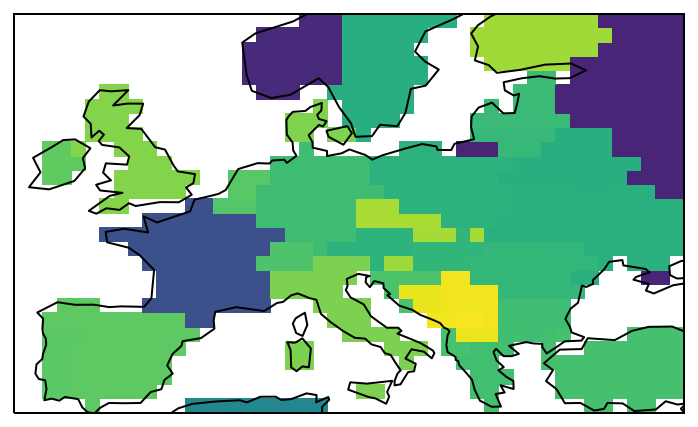

In [73]:
fig = plt.figure(figsize=[6, 6])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

low = mask.min()
high = mask.max()

levels = np.arange(low - 0.5, high + 1)

mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), levels=levels, add_colorbar=False)
#regionmask.defined_regions.natural_earth.countries_110.plot(label='abbrev')
ax.coastlines()
# fine tune the extent
ax.set_extent([-11, 36, 36, 64], crs=ccrs.PlateCarree());

We want to select the country 'GB'. Thus we first need to find out which number this is:

## Select using `groupby`

In [74]:
# you can group over all integer values of the mask
# you have to take the sum over `stacked_lat_lon`
co2_all = dr.groupby(mask).sum('stacked_lat_lon')
#co2_all

we can add the abbreviations and names of the regions to the DataArray

In [75]:
# extract the abbreviations and the names of the regions from regionmask
abbrevs = regionmask.defined_regions.natural_earth.countries_110[co2_all.region.values].abbrevs
names = regionmask.defined_regions.natural_earth.countries_110[co2_all.region.values].names

co2_all.coords['abbrevs'] = ('region', abbrevs)
co2_all.coords['names'] = ('region', names)
#co2_all
#regionmask.defined_regions.natural_earth.countries_110.names

## selected countries 

In [76]:
countries = ['Germany', 'United Kingdom', 'Italy', 'France', 'Poland', 'Spain']
co2_TNO = [791558, 414196, 353471, 343866, 310313, 269328]
co2_ODIAC = [741637, 449039, 349905, 323712, 295725, 258421]
co2_new = np.arange(len(countries))
for count, name in enumerate(countries):
    co2_new[count] = co2_all.isel(region=(co2_all.names == countries[count]))
co2_new

array([199498,  99073,  74508,  79211,  77178,  52951])

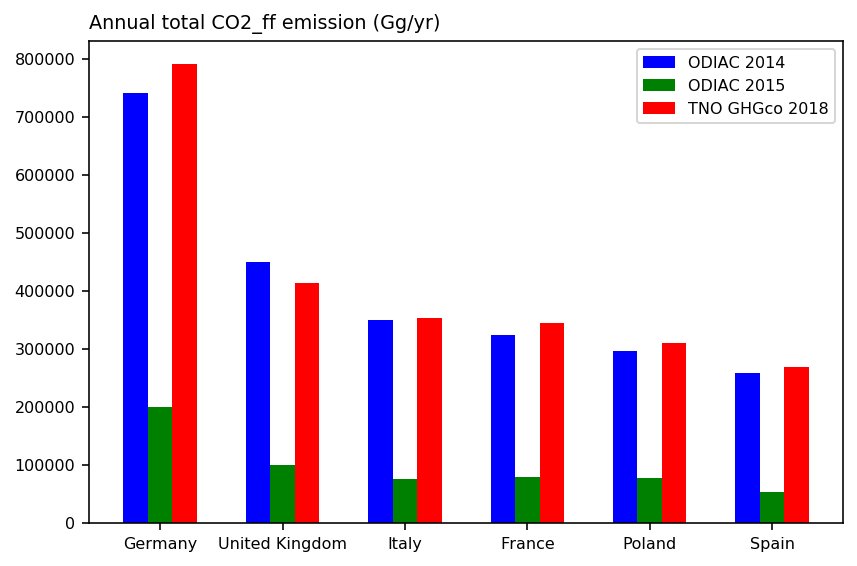

In [77]:
bar_pos = np.arange(len(countries)) + 1 # position of the bars

fig = plt.figure(figsize=[6, 4])
width = 0.2
bars_ODIAC = plt.bar(bar_pos-0.2, co2_ODIAC, width=width, color = 'b', label='ODIAC 2014')
bars_EDGAR = plt.bar(bar_pos, co2_new, width=width, color = 'g', label= name_ds + ' ' + year)
bars_TNO = plt.bar(bar_pos+0.2, co2_TNO, width=width, color = 'r', label='TNO GHGco 2018')

plt.xticks(bar_pos, countries)
plt.title('Annual total CO2_ff emission (Gg/yr)', loc='left')
plt.legend()

fig.tight_layout()


#fig.savefig('../plots/EDGAR_TNO_ODIAC_countries.png', dpi=300)